# **Multi-GPU Particle Mesh Simulation with Halo Exchange**

<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/02-MultiGPU_PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install diffrax

> **Note**: This notebook requires 8 devices (GPU or TPU).\
> If you're running on CPU or don't have access to 8 devices,\
> you can simulate multiple devices by adding the following code at the start **BEFORE IMPORTING JAX**:

```python
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
```

**Recommended only for debugging**. If used, you must probably lower the resolution of the mesh.

In [ ]:
import os
os.environ["EQX_ON_ERROR"] = "nan"
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax.debug import visualize_array_sharding

from jaxpm.kernels import interpolate_power_spectrum
from jaxpm.painting import cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_diffrax_ode
from functools import partial
from diffrax import ConstantStepSize, LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve

In [2]:
assert jax.device_count() >= 8, "This notebook requires a TPU or GPU runtime with 8 devices"

### Setting Up Device Mesh and Sharding for Multi-GPU Simulation

This cell configures a **2x4 device mesh** across 8 devices and sets up named sharding to distribute data efficiently.

- **Device Mesh**: `pdims = (2, 4)` arranges devices in a 2x4 grid.
- **Sharding with Mesh**: `Mesh(devices, axis_names=('x', 'y'))` assigns the mesh grid axes, which allows flexible mapping of array data across devices.
- **PartitionSpec and NamedSharding**: `PartitionSpec` defines data partitioning across mesh axes `('x', 'y')`, and `NamedSharding(mesh, P('x', 'y'))` specifies this sharding scheme for arrays in the simulation.

More info on Sharding in general in [Distributed arrays and automatic parallelization](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html)

In [ ]:
from jax.experimental.multihost_utils import process_allgather
from jax.sharding import PartitionSpec as P, NamedSharding

all_gather = partial(process_allgather, tiled=True)

pdims = (2, 4)
mesh = jax.make_mesh(pdims, axis_names=('x', 'y'))
sharding = NamedSharding(mesh, P('x', 'y'))

### Multi-GPU Particle Mesh Simulation with Sharding

This function is very similar to the single-GPU implementation, with the key difference being that `linear_field`, `lpt`, and `make_ode_fn` now take a `sharding` argument. This allows each stage of the simulation—initial conditions, displacements, and ODE evolution—to be distributed across the configured 2x4 device mesh, ensuring efficient parallel execution.


In [ ]:
mesh_shape = 256
box_size = 256.
halo_size = 32
snapshots = (0.5, 1.0)

@partial(jax.jit , static_argnums=(2,3,4,5))
def run_simulation(omega_c, sigma8,mesh_shape,box_size,halo_size , snapshots):
    mesh_shape = (mesh_shape,) * 3
    box_size = (box_size,) * 3
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(
        jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: interpolate_power_spectrum(x, k, pk, sharding)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape,
                                      box_size,
                                      pk_fn,
                                      seed=jax.random.PRNGKey(0),
                                      sharding=sharding)


    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo,
                   initial_conditions,
                   a=0.1,
                   order=2,
                   halo_size=halo_size,
                   sharding=sharding)

    # Evolve the simulation forward
    ode_fn = ODETerm(
        make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False , sharding=sharding))
    solver = Tsit5()

    stepsize_controller = PIDController(rtol=1e-6 , atol=1e-6)
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)
    ode_solutions = [sol[0] for sol in res.ys]
    return initial_conditions, dx, ode_solutions, res.stats

initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)
ode_solutions[-1].block_until_ready()
%timeit initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8, mesh_shape, box_size , halo_size , snapshots);ode_solutions[-1].block_until_ready()
print(f"Solver Stats : {solver_stats}")

778 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(90, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(90, dtype=int32, weak_type=True)}



All fields and particle grids remain distributed at all times (as seen below). `jaxPM` ensures they are **never gathered on a single device**. In a forward model scenario, it’s the **user's responsibility to maintain distributed data** to avoid memory bottlenecks.


In [5]:
visualize_array_sharding(ode_solutions[-1][:,:,0,0])

                                    
                                    
  GPU 0    GPU 1    GPU 2    GPU 3  
                                    
                                    
                                    
                                    
                                    
  GPU 4    GPU 5    GPU 6    GPU 7  
                                    
                                    
                                    

> ⚠️ **Warning**: One caveat is that particle arrays usually have a shape of `(NPart, 3)`,\
> where `NPart = Nx * Nx * Nx`. However, this shape is **not shardable** in a distributed setup.\
> Instead, particle arrays will always have a shape of `(Nx, Ny, Nz, 3)` to ensure they remain distributed across devices.


In [6]:
initial_conditions_g = all_gather(initial_conditions)
lpt_displacements_g = all_gather(lpt_displacements)
ode_solutions_g = [all_gather(p) for p in ode_solutions]

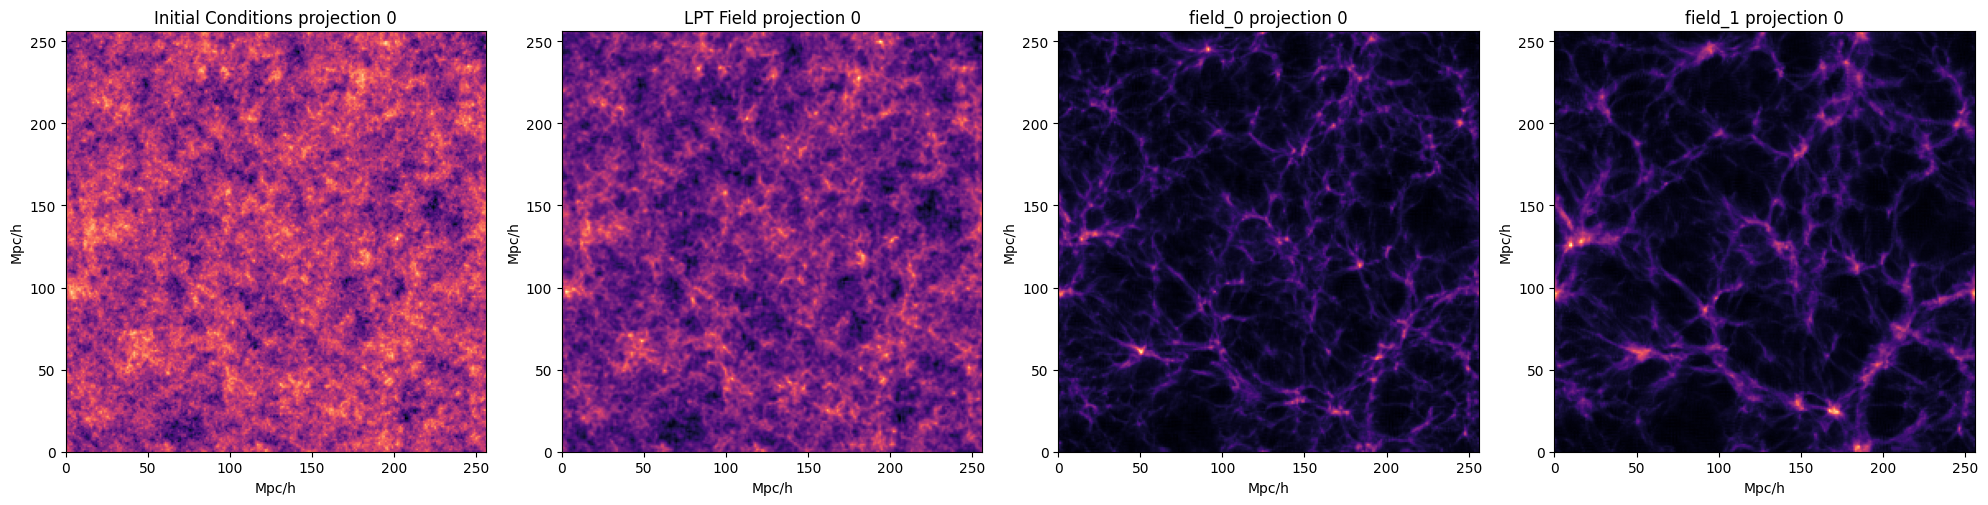

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field)
plot_fields_single_projection(fields,project_axis=1)

# **Halo Exchange**

Let's start by running a simulation **without halo exchange**. Here, we set `halo_size = 0`, which means no overlapping regions between device boundaries. This configuration helps us observe the limitations of simulations without halo regions, especially for calculating forces near boundaries in multi-GPU setups.


In [ ]:
mesh_shape = 256
box_size = 256.
halo_size = 0
snapshots = (0.5, 1.0)

initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)

initial_conditions_g = all_gather(initial_conditions)
lpt_displacements_g = all_gather(lpt_displacements)
ode_solutions_g = [all_gather(p) for p in ode_solutions]

from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field)
plot_fields_single_projection(fields,project_axis=1)

We can see very faint lines in the visualization, but the boundary conditions were handled successfully even without halo exchange. 

**Important**: Here, we painted the **all-gathered field** for visualization, which in a typical forward model should be avoided to maintain data distribution.

Next, we’ll modify the simulation function to return density fields directly, allowing us to observe the impact of the `halo_size` on boundary accuracy.


In [ ]:
mesh_shape = 256
box_size = 256.
halo_size = 0
snapshots = (0.5, 1.0)

@partial(jax.jit , static_argnums=(2,3,4,5))
def run_simulation_with_fields(omega_c, sigma8,mesh_shape,box_size,halo_size , snapshots):
    mesh_shape = (mesh_shape,) * 3
    box_size = (box_size,) * 3
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(
        jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: interpolate_power_spectrum(x, k, pk, sharding)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape,
                                      box_size,
                                      pk_fn,
                                      seed=jax.random.PRNGKey(0),
                                      sharding=sharding)


    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo,
                   initial_conditions,
                   a=0.1,
                   order=2,
                   halo_size=halo_size,
                   sharding=sharding)

    # Evolve the simulation forward
    ode_fn = ODETerm(
        make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False , sharding=sharding , halo_size=halo_size))
    solver = Tsit5()

    stepsize_controller = PIDController(rtol=1e-6 , atol=1e-6)
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)
    ode_fields = [cic_paint_dx(sol[0], halo_size=halo_size, sharding=sharding) for sol in res.ys]
    lpt_field = cic_paint_dx(dx , halo_size=halo_size, sharding=sharding)
    return initial_conditions, lpt_field, ode_fields, res.stats

initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)
print(f"Solver Stats : {solver_stats}")

Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(90, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(90, dtype=int32, weak_type=True)}


In [75]:
initial_conditions_g = all_gather(initial_conditions)
lpt_field_g = all_gather(lpt_field)
ode_fields_g = [all_gather(p) for p in ode_fields]

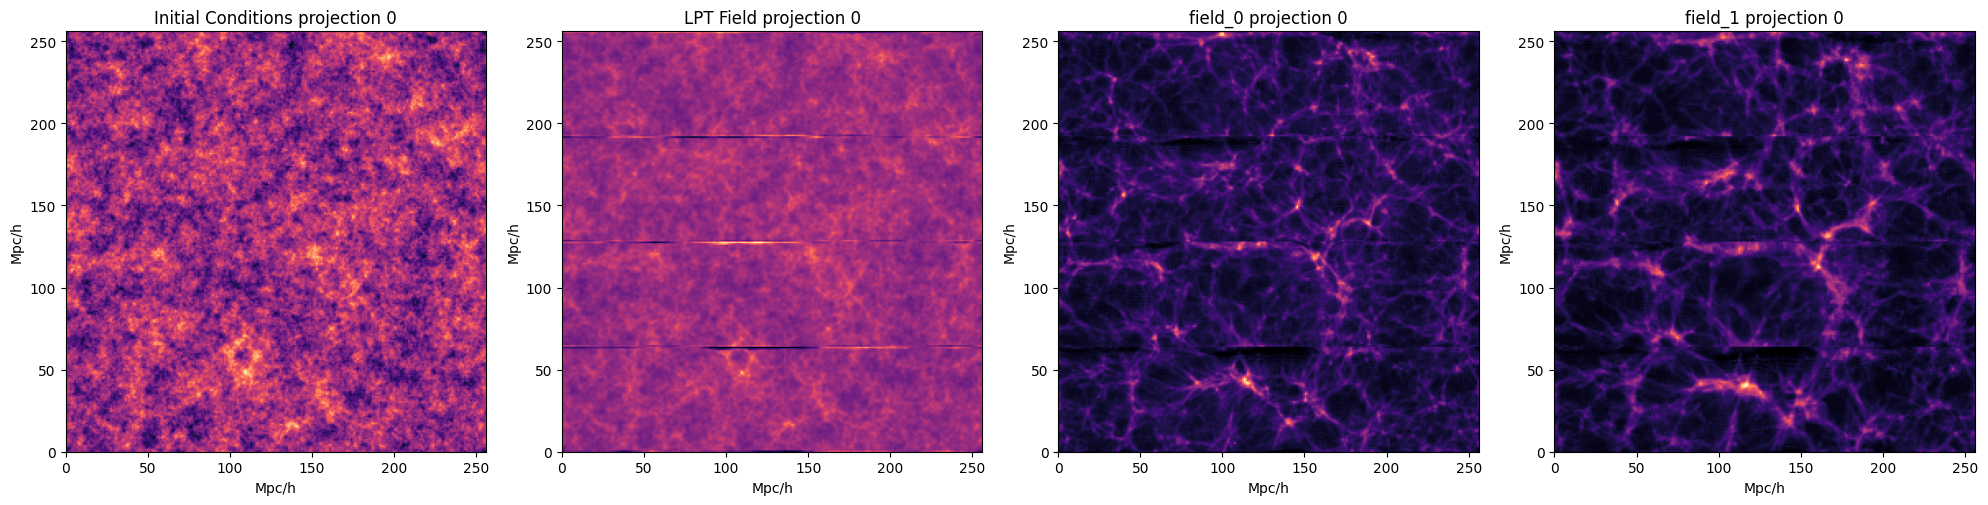

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions_g , "LPT Field" : lpt_field_g}
for i , field in enumerate(ode_fields_g):
    fields[f"field_{i}"] = field
plot_fields_single_projection(fields,project_axis=0)

Now we can see that there are very apparent lines between the subdomains of the simulation. These lines highlight the **artifacts** that arise when running the simulation without a halo exchange, as boundary conditions are not accurately handled across device edges.


### Choosing the Right Halo Size

In some cases, the halo size can be too small, leading to visible artifacts in the snapshots. Here, we see that boundaries are handled well in the first and second snapshots, but the lines become more pronounced with each successive step. This indicates that a larger halo size may be needed to fully capture interactions across device boundaries over time.


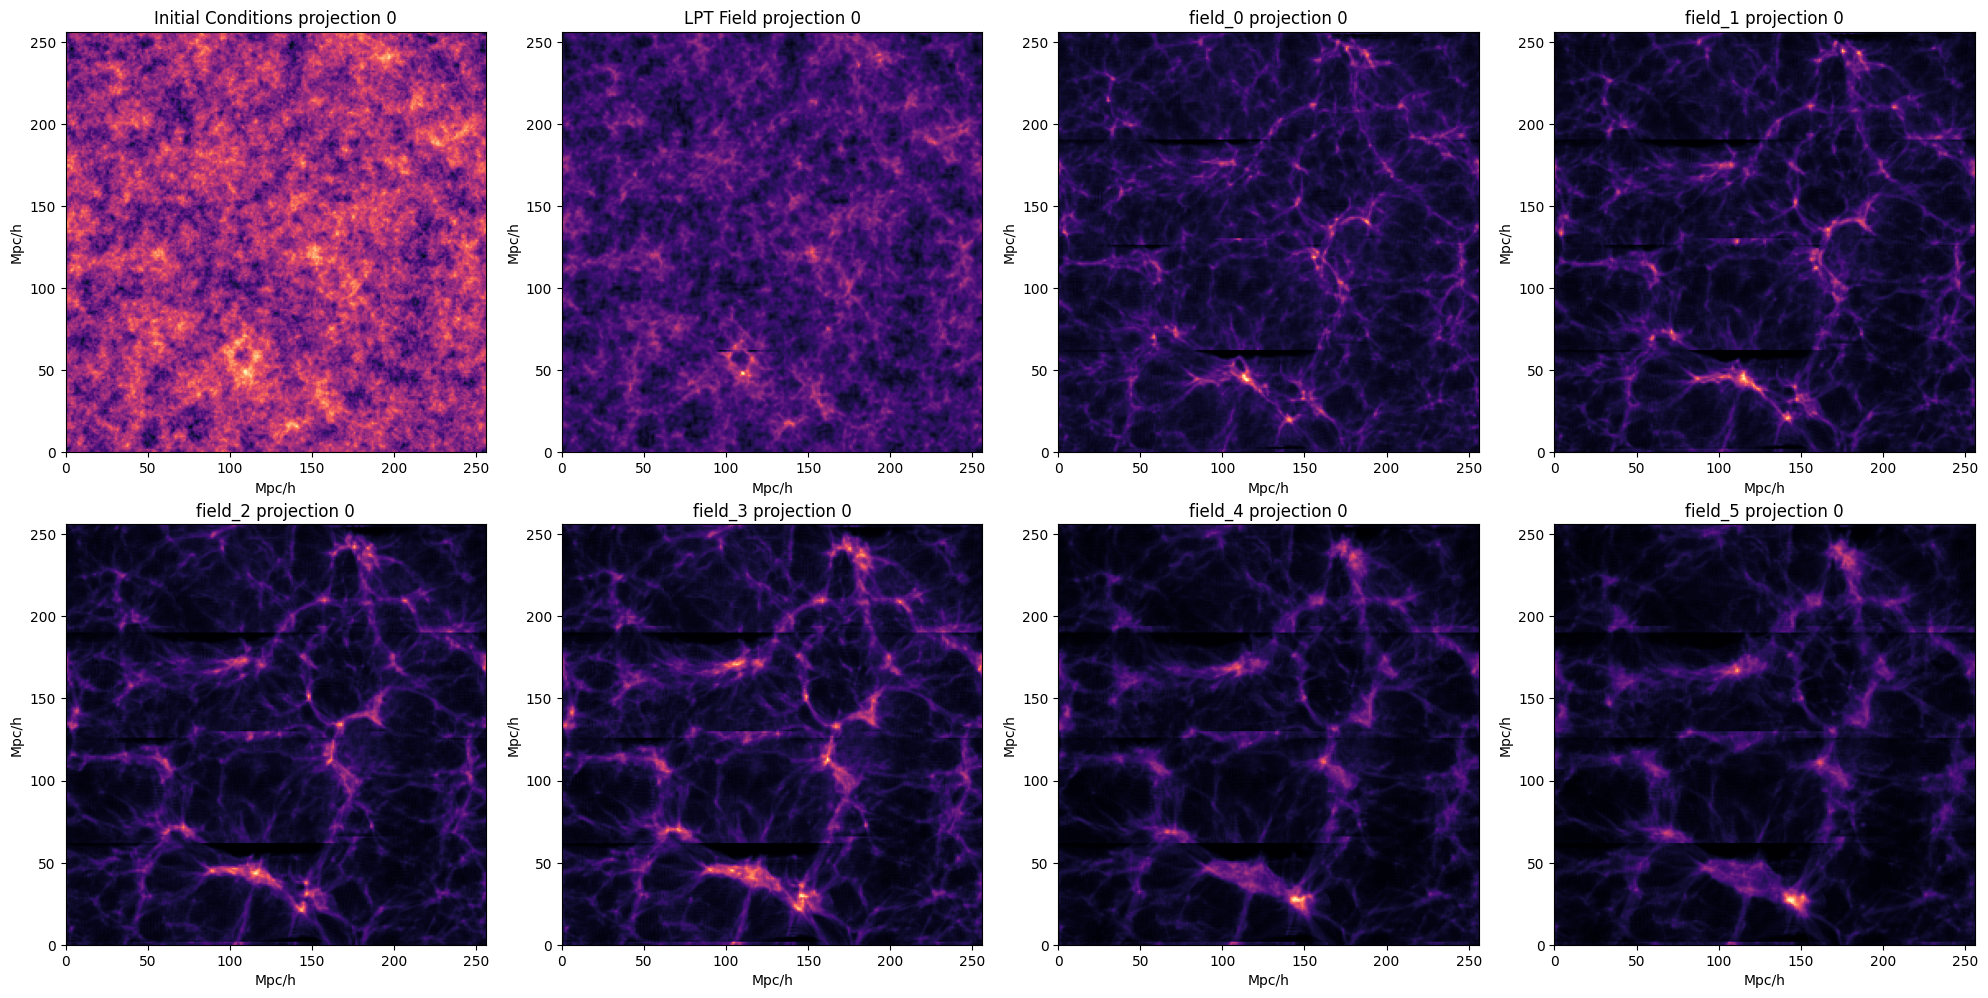

In [81]:
mesh_shape = 256
box_size = 128.
halo_size = 4
snapshots = (0.3 ,0.4, 0.5 , 0.6, 0.8, 1.0)

initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)

initial_conditions_g = all_gather(initial_conditions)
lpt_field_g = all_gather(lpt_field)
ode_fields_g = [all_gather(p) for p in ode_fields]

fields = {"Initial Conditions" : initial_conditions_g , "LPT Field" : lpt_field_g}
for i , field in enumerate(ode_fields_g):
    fields[f"field_{i}"] = field
plot_fields_single_projection(fields,project_axis=0)

In other cases, if the **box size is too large**, particles must cover greater distances, resulting in smaller final displacements. This reduces the impact of insufficient halo size on boundary artifacts. 

### Explanation

- **Large Box Sizes**: In larger simulation boxes, particles tend to have smaller relative displacements (or slower speeds). This reduces the frequency of interactions with particles in neighboring subdomains, making boundary artifacts less pronounced, even if the halo size is smaller.

- **Smaller Box Sizes**: In smaller boxes, particles cover a greater relative distance, leading to more frequent interactions with boundary particles. Here, the halo size must be carefully chosen to capture these interactions accurately, reducing visible artifacts in the visualization.


In this scenario, we can see that the insufficient halo size does not lead to severe artifacts, as particles are less affected by neighboring boundaries.


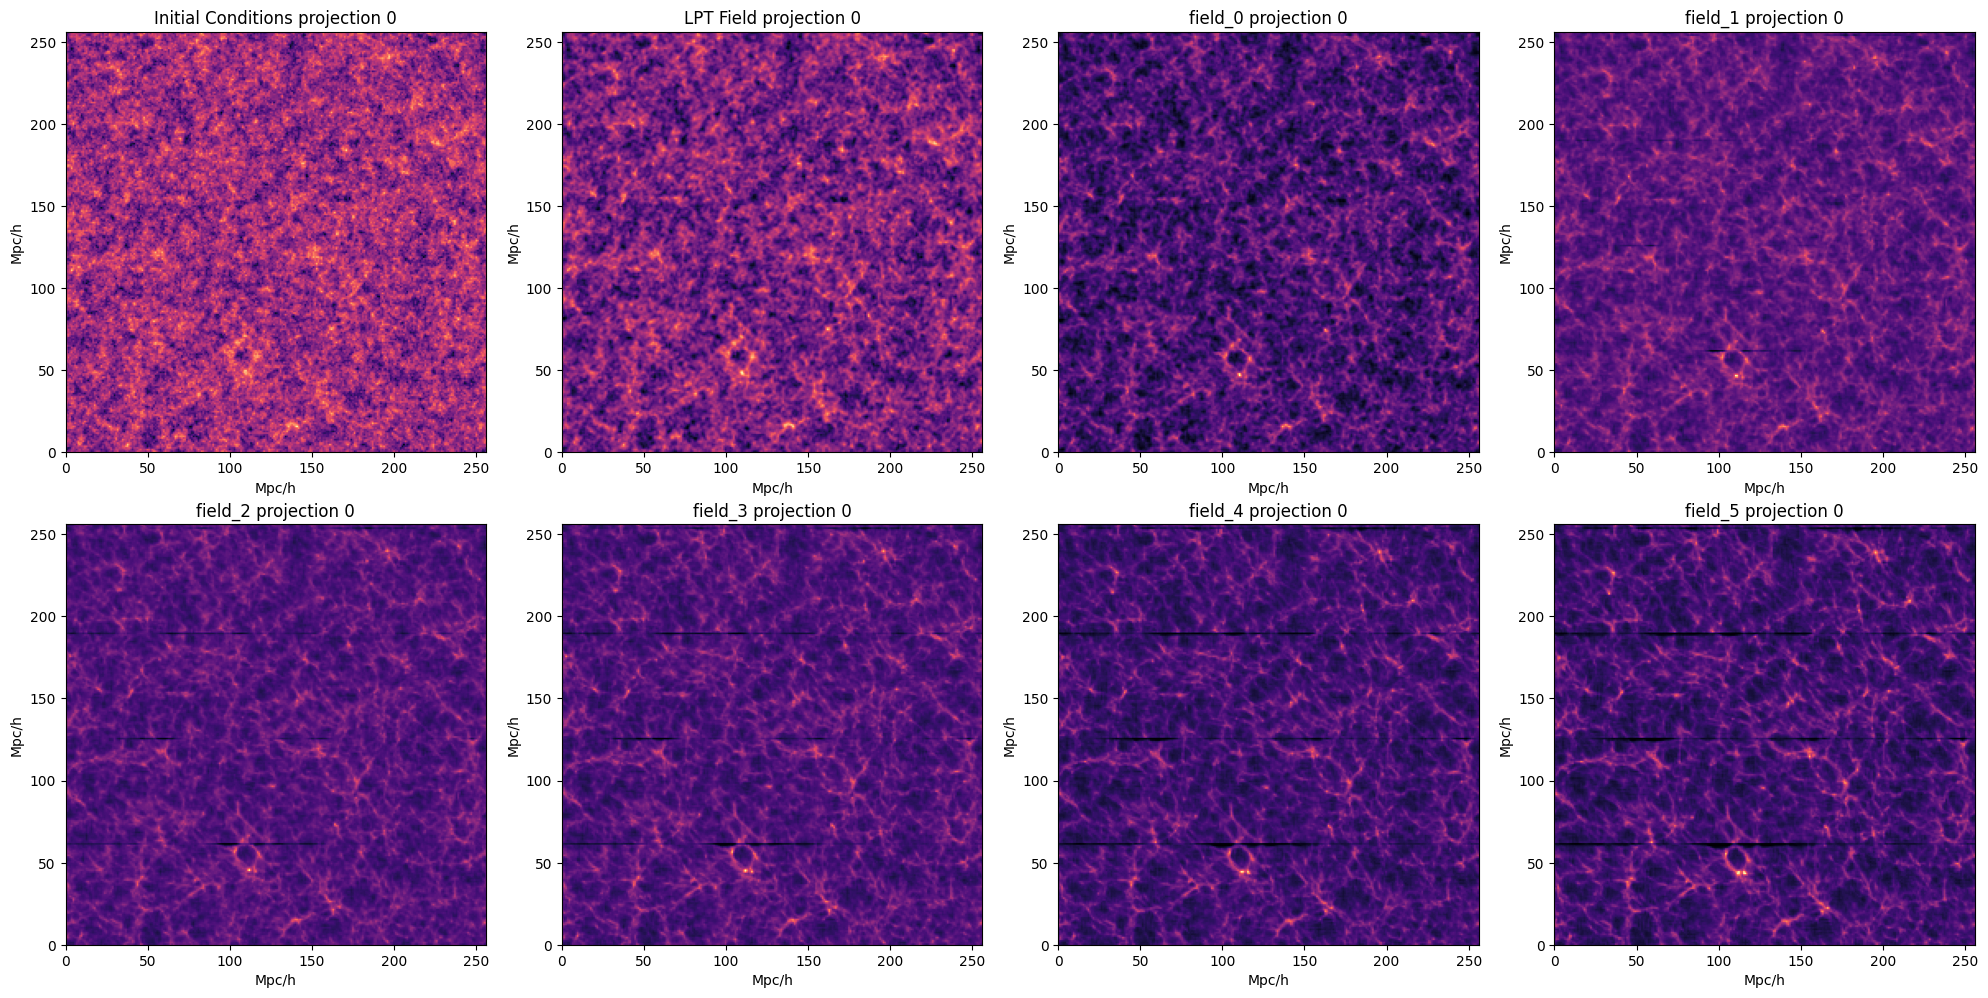

In [82]:
mesh_shape = 256
box_size = 1000.
halo_size = 4
snapshots = (0.3 ,0.4, 0.5 , 0.6, 0.8, 1.0)

initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)

initial_conditions_g = all_gather(initial_conditions)
lpt_field_g = all_gather(lpt_field)
ode_fields_g = [all_gather(p) for p in ode_fields]

fields = {"Initial Conditions" : initial_conditions_g , "LPT Field" : lpt_field_g}
for i , field in enumerate(ode_fields_g):
    fields[f"field_{i}"] = field
plot_fields_single_projection(fields,project_axis=0)

### General Guideline

<span style="font-size: 1.1em;">Start with a halo size that is **one-eighth of the box size**. Gradually reduce it until you begin to notice lines in the visualization, indicating an insufficient halo size.</span>


# Applying Weights in a Distributed Setup

We can apply weights just like before. In general, we want to apply weights on a **distributed particle grid**.

> **Note**: When using weights in a distributed setting, ensure that the weights have the **same sharding** as the particle grid. If the sharding is not identical, JAX may perform an all-gather or other collective operations that could significantly impact performance.


                                    
                                    
  GPU 0    GPU 1    GPU 2    GPU 3  
                                    
                                    
                                    
                                    
                                    
  GPU 4    GPU 5    GPU 6    GPU 7  
                                    
                                    
                                    

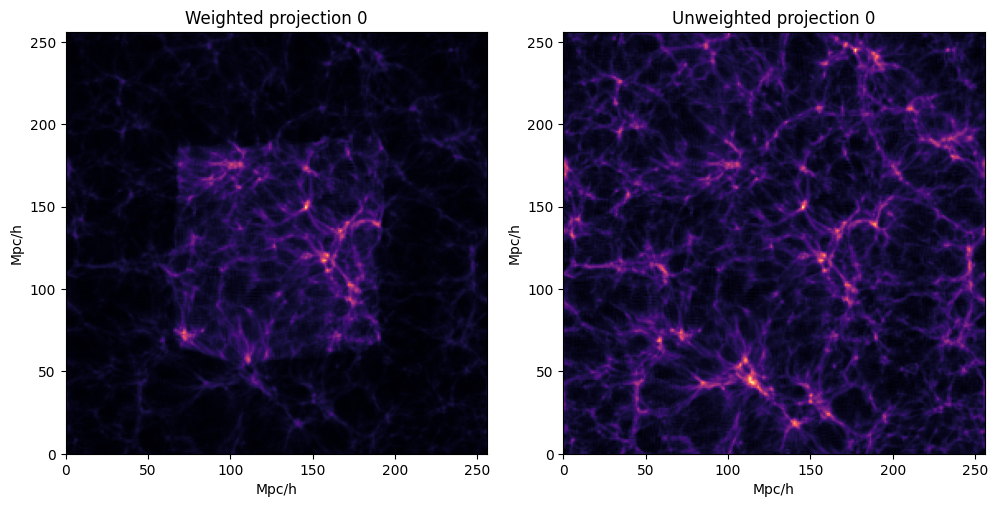

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

field = ode_solutions[0]

center = slice(field.shape[0] // 4, 3 * field.shape[0] // 4 )
center3d = (slice(None) , center,center)  # All of X, Y=0, Z=0
weights = jnp.ones_like(field[...,0])
# Update weights for the down-left pencil by multiplying by 100
weights = weights.at[center3d].multiply(3)
visualize_array_sharding(weights[:,:,0])

weighted = cic_paint_dx(field, weight=weights)
unweighted = cic_paint_dx(field, weight=2.0)

plot_fields_single_projection({"Weighted" : weighted , "Unweighted" : unweighted} , project_axis=0)